<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-Corrected60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import zipfile
from io import BytesIO
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from IPython.display import Image, display_svg, SVG

import tensorflow as tf
import torch
import fastbook as fastai
fastai.setup_book()
from fastai import tabular
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [2]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
#filename = "train-events-20-min.zip"

#Train reportings 15 minutes apart - everything we have collected
filename = "train-data-master.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 30.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 60.0 }

dep_var = 'nextValue'

#Determines the portion of data to train versus validate
dataCutpoint = .80

In [3]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-master.zip...
/ [1 files][236.7 MiB/236.7 MiB]                                                
Operation completed over 1 objects/236.7 MiB.                                    


In [4]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   21:16:05
2000   21:16:16
3000   21:16:25
4000   21:16:30
5000   21:16:37
6000   21:16:43
7000   21:16:48
8000   21:16:54
9000   21:16:59
10000   21:17:05
11000   21:17:11
12000   21:17:17
13000   21:17:23
14000   21:17:27
15000   21:17:34
16000   21:17:38
17000   21:17:46
18000   21:17:51
19000   21:17:59
20000   21:18:04
21000   21:18:11
22000   21:18:15
23000   21:18:23
24000   21:18:28
25000   21:18:32
26000   21:18:41
27000   21:18:45
28000   21:18:49
29000   21:18:58
30000   21:19:02
31000   21:19:06
32000   21:19:15
33000   21:19:20
34000   21:19:24
35000   21:19:30
36000   21:19:40
37000   21:19:44
38000   21:19:49


In [5]:
print(type(trains))
print(type(trains[1]))
trains[1]

<class 'dict'>
<class 'pandas.core.frame.DataFrame'>


,ptcLeadLocomotiveId,positionHistoryList,locomotiveList,subdivisionList,...,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,aotuTrainData.eventCode,aotuTrainData.routeLocationList
0,BNSF7601,"[{'positionTime': '2022-05-19T07:31:04Z', 'speedMPH': -12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EAST MAIN', 'milepost': {'milepostNumber': 766.9251}}}, {'positionTime': '2022-05-19T07:29:16Z', 'speedMPH': -12, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 279.2352}}}, {'positionTime': '2022-05-19T07:28:44Z', 'speedMPH': -13, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 279.3427}}}, {'positionTime': '2022-05-19T07:28:09Z', 'speedMPH': -13, 'milepostLocation': {'subdivisionI...",[],"[{'subdivisionId': 595}, {'subdivisionId': 538}, {'subdivisionId': 605}, {'subdivisionId': 599}]",...,0,0,0,[]


In [6]:
dfTrainsAll = pd.concat(trains.values())

In [7]:
del trains

In [8]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

Filter out MP outside of Boone

In [9]:
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] < 327]
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] > 201]


In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29770 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            29770 non-null  object 
 1   positionHistoryList                                            29770 non-null  object 
 2   locomotiveList                                                 29770 non-null  object 
 3   subdivisionList                                                29770 non-null  object 
 4   trainEstimatedPositionList                                     29770 non-null  object 
 5   trainActualPositionList                                        29770 non-null  object 
 6   trainId.trainSCAC                                              29728 non-null  object 
 7   trainId.trainSection                                          

# Create a learning set to modify

In [11]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [12]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [13]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [14]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


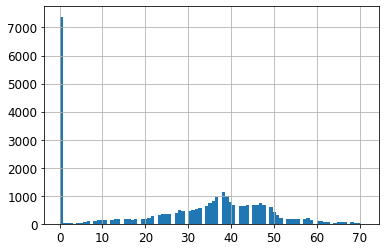

In [15]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [16]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [17]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [18]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['M' 'U' 'E' 'G' 'C' 'A' 'I' 'W' 'Z' 'S' 'L' 'P']
['MT 1' 'MT 2' 'EASTXO' 'N SIDING' 'WESTXO' 'YD LD' '136' 'XO' '806' '405' '113']
['UP' 'UNK']
['' '2']
[4. 1. 3. 0.]
[12.  8. 15.  4.  2. 10. 19. 17. 11. 14.  0.]
[2. 1. 0.]
[2. 3. 0.]
['' 0.0]
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [19]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[60. 70. 50. 40. 88. 45. 79.  0. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [20]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [21]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [22]:
dfTrainsLearn['workLocations'].unique()

array(['202.20', '258.40,202.20', None, '225.10', '202.20,258.40,321.50', '314.52,202.20', '321.50,202.20', '231.80,225.10', '214.50', '225.10,202.20', '202.20,258.40', '202.20,219.70',
       '219.70,202.20', '202.20,214.50,225.10,290.80,304.10', '202.20,258.40,225.10', '202.20,219.90,225.10', '202.20,257.60', '250.50,202.20', '268.40,202.20', '258.40,207.60,202.20',
       '207.60,202.20', '241.00,202.20', '258.40,219.70,202.20', '202.20,314.52', '202.92,202.20', '214.50,225.10,290.80,304.10,202.20', '290.80,258.40,231.80,202.20', '202.20,290.80',
       '202.20,299.75', '314.52,225.10,202.20', '202.20,219.70,277.50', '202.20,293.10', '202.20,304.10', '321.50,314.52,202.20', '202.20,240.90', '202.20,265.30', '265.30,202.20', '202.20,286.40',
       '240.90,207.60,202.20', '250.50,245.90,202.20', '219.70', '202.20,312.80', '321.50,240.90,202.20', '240.90,202.20', '202.20,207.60', '202.20,225.10', '326.20,214.50', '214.50,202.20',
       '240.90,214.50,202.20', '278.10,258.40,202.20', 

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [23]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [24]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [25]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.subdivisionId'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.trackName'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])

You can peer into the incoming data here:

In [26]:
idx = 1
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

NS1007
MGBNP
106
MT 1
209.8707


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-09T19:40:07Z,0,106,MT 1,209.87070
1,2022-06-09T19:42:07Z,0,106,MT 1,209.87070
2,2022-06-09T19:44:07Z,5,106,MT 1,210.15358
3,2022-06-09T19:46:07Z,11,106,MT 1,210.46217
4,2022-06-09T19:48:07Z,17,106,MT 1,210.88560
...,...,...,...,...,...
52,2022-06-09T21:26:07Z,35,106,MT 1,281.16560
53,2022-06-09T21:28:07Z,42,106,MT 1,282.40717
54,2022-06-09T21:30:07Z,49,106,MT 1,283.95746
55,2022-06-09T21:34:07Z,62,106,MT 1,287.82657


In [27]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,202.2072,"[{'positionTime': '2022-06-09T19:20:40Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 202.2072}}}, {'positionTime': '2022-06-09T19:22:40Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.70474}}}, {'positionTime': '2022-06-09T19:24:40Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 205.29929}}}, {'positionTime': '2022-06-09T19:26:40Z', 'speedMPH': 53, 'milepostLocation': {'subdivisionId': 106..."
0,209.8707,[]
0,216.5130,"[{'positionTime': '2022-06-09T19:54:41Z', 'speedMPH': 26, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 216.513}}}, {'positionTime': '2022-06-09T19:56:41Z', 'speedMPH': 32, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 217.47511}}}, {'positionTime': '2022-06-09T19:58:41Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 218.65654}}}, {'positionTime': '2022-06-09T20:00:41Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106,..."
0,224.2101,"[{'positionTime': '2022-06-09T20:11:30Z', 'speedMPH': 31, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 224.2101}}}, {'positionTime': '2022-06-09T20:13:30Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 225.32594}}}, {'positionTime': '2022-06-09T20:15:30Z', 'speedMPH': 41, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 226.61711}}}, {'positionTime': '2022-06-09T20:17:30Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106..."
0,235.8908,"[{'positionTime': '2022-06-09T20:27:41Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 235.8908}}}, {'positionTime': '2022-06-09T20:29:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 237.54869}}}, {'positionTime': '2022-06-09T20:31:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 238.9238}}}, {'positionTime': '2022-06-09T20:33:41Z', 'speedMPH': 44, 'milepostLocation': {'subdivisionId': 106,..."
...,...,...
0,217.0825,[]
0,215.1352,"[{'positionTime': '2022-06-04T01:18:01Z', 'speedMPH': -16, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 215.1352}}}, {'positionTime': '2022-06-04T01:20:01Z', 'speedMPH': -20, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 214.52847}}}, {'positionTime': '2022-06-04T01:22:01Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 210.82147}}}, {'positionTime': '2022-06-04T01:24:01Z', 'speedMPH': -28, 'milepostLocation': {'subdivisionId':..."
0,207.0881,[]
0,207.0909,[]


Renumber the list

In [28]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [29]:
def findEntryAtTime(actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]
  return pd.Series()

In [30]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  entry = findEntryAtTime(actualsEntry, timeInMinutes)
  if (entry.empty):
    return None
  return (abs(entry['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))

In [31]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [32]:
def findNextMilepostAtTime(actualsEntry, timeInMinutes):
  entry = findEntryAtTime(actualsEntry, timeInMinutes)
  if (entry.empty):
    return None
  return entry['milepostLocation.milepost.milepostNumber']  

In [33]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [34]:
beopJSON = dfTrainsBeop.iloc[3291]['trainEstimatedPositionList']
beopDT = pd.json_normalize(beopJSON)
print(beopDT)

            positionTime  speedMPH  milepostLocation.subdivisionId  \
0   2022-05-11T10:25:35Z        39                             106   
1   2022-05-11T10:27:35Z        40                             106   
2   2022-05-11T10:29:35Z        40                             106   
3   2022-05-11T10:31:35Z        40                             106   
4   2022-05-11T10:33:35Z        48                             106   
..                   ...       ...                             ...   
56  2022-05-11T12:17:35Z        50                             106   
57  2022-05-11T12:19:35Z        50                             106   
58  2022-05-11T12:21:35Z        50                             106   
59  2022-05-11T12:23:35Z        50                             106   
60  2022-05-11T12:25:35Z        50                             106   

   milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                        MT 2                                 320.46980  
1          

In [35]:
dfTrainsLearnActuals.iloc[3291]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-05-11T10:27:35Z,38,106,MT 2,321.73276
1,2022-05-11T10:29:35Z,37,106,MT 2,322.98834
2,2022-05-11T10:31:35Z,31,106,MT 2,324.09690
3,2022-05-11T10:33:35Z,22,106,MT 2,325.04443
4,2022-05-11T10:35:35Z,5,106,MT 2,325.57175
...,...,...,...,...,...
39,2022-05-11T11:45:35Z,0,106,MT 2,325.69920
40,2022-05-11T11:47:35Z,0,106,MT 2,325.69900
41,2022-05-11T11:49:35Z,0,106,MT 2,325.69900
42,2022-05-11T11:51:35Z,2,106,MT 2,325.77545


In [36]:
idx = 3291
distMI = 10
timeMin = 15  
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], distMI)
print("Next Entry in ",distMI," Miles: \n",nextActual)
nextActual = findEntryAtTime(dfTrainsLearnActuals.iloc[idx], timeMin)
print("Entry in ",timeMin," Min: ",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearnActuals.iloc[idx], timeMin)
print("Milepost in ",timeMin," Min: ",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, distMI)
  print("Next Beop in ",distMI," miles: \n",nextBeop)
  nextBeop = findEntryAtTime(beopDT, timeMin)
  print("Beop in ",timeMin," Min: ",nextBeop)
  print(type(nextBeop))
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP2706
MCHCB
106
MT 2
320.4698
Reported speed:  39
Reported MP:  320.4698
Reported Time:  2022-05-11T10:25:35Z
Next Entry in  10  Miles: 
 []
Entry in  15  Min:  positionTime                                2022-05-11T10:41:35Z
speedMPH                                                       0
milepostLocation.subdivisionId                               106
milepostLocation.trackName                                  MT 2
milepostLocation.milepost.milepostNumber                 325.699
Name: 7, dtype: object
Milepost in  15  Min:  325.699
actual Value:  325.699
Next Beop in  10  miles: 
            positionTime  speedMPH  milepostLocation.subdivisionId  \
7  2022-05-11T10:39:35Z        50                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
7                       MT 2                                 330.95325  
Beop in  15  Min:  positionTime                                2022-05-11T10:39:35Z
speedMPH                                

Run the calulations.  This will take a moment.

In [37]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [38]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([232.89471, 243.68625, 257.6546 , ..., 217.01894, 207.47801, 205.17145])

NextValue values histogram:


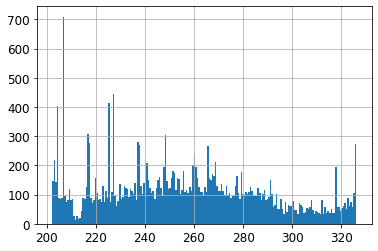

In [39]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [40]:
dfTrainsLearn['beopValue'].unique()

array([260.1106 ,       nan, 269.0104 , ..., 186.3567 , 176.57133, 174.76186])

physics predictions histogram:


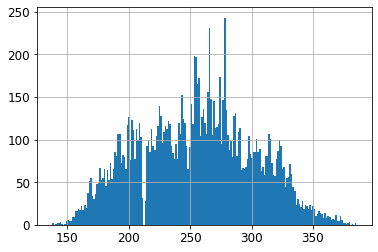

In [41]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [42]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [43]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [44]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,NS1007,UP,,MGBNP,...,False,False,False,1.654802e+09
1,NS1007,UP,,MGBNP,...,False,False,False,1.654803e+09
2,NS1007,UP,,MGBNP,...,False,False,False,1.654804e+09
3,NS1007,UP,,MGBNP,...,False,False,False,1.654805e+09
4,NS1007,UP,,MGBNP,...,False,False,False,1.654806e+09
...,...,...,...,...,...,...,...,...,...
29762,UP7942,UP,,MNPCH,...,False,False,False,1.654301e+09
29763,UP7942,UP,,MNPCH,...,False,False,False,1.654302e+09
29764,UP7942,UP,,MNPCH,...,False,False,False,1.654303e+09
29765,UP7942,UP,,MNPCH,...,False,False,False,1.654304e+09


In [45]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(22510, 47)
(29770,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 29766
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            22510 non-null  object        
 1   trainId.trainSCAC                                              22510 non-null  category      
 2   trainId.trainSection                                           22510 non-null  category      
 3   trainId.trainSymbol                                            22510 non-null  object        
 4   trainId.trainDate                                              22510 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  22510 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            22510 non-

# Use Decision Tree to predict next value

In [46]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [47]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
90      50
91     177
92     187
93     176
94      94
      ... 
183    288
184    211
185    211
186    214
187    360
Name: lastReportedPosition.positionTimeDayofyear, Length: 97, dtype: int64


In [48]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * dataCutpoint)])

We will partition this set at day of year: 167


In [49]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * dataCutpoint)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [50]:
#dep_var = 'nextSpeed'

In [51]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [52]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

Length of Training And Validation Sets:

In [53]:
trainingLength = len(to.train)
validationLength= len(to.valid)
trainingLength, validationLength

(18149, 4361)

In [54]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
0,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,42,202.207199,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,60.0,102.0,0.0,9738.0,7158.0,202,2,6,23,9,3,160,1.654802e+09,232.894714
1,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,0,209.870697,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,209,2,6,23,9,3,160,1.654803e+09,243.686249
2,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,26,216.513000,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,216,2,6,23,9,3,160,1.654804e+09,257.654602
3,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,31,224.210098,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,224,2,6,23,9,3,160,1.654806e+09,269.569092
4,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,36,235.890793,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,235,2,6,23,9,3,160,1.654806e+09,283.609772
5,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,62,246.540100,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,246,2,6,23,9,3,160,1.654807e+09,302.337982
6,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,50,260.289795,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,260,2,6,23,9,3,160,1.654808e+09,317.759552
31,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,33,202.206802,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,202,4,6,22,4,5,155,1.654303e+09,243.997238
32,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,54,220.706604,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,220,4,6,22,4,5,155,1.654304e+09,260.171692
33,NS4141,UP,,MGBNP,2022-06-02,106,MT 2,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,39,231.671707,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0

# Measure the Physics BEoP Root Mean Standard Error (RMSE) on Validation Set

In [55]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [56]:
def showPredictions(predictionsSeries, validSeries):
  b = predictionsSeries.reset_index(drop=true)
  y = validSeries.reset_index(drop=true)
  
  df  = pd.concat([b, y], axis=1)
  df = df.dropna()
  df = df.rename(columns={ df.columns[0]: "prediction", df.columns[1]: "actual" })
  df['delta'] = abs(df["prediction"] - df["actual"])
  print(df)
  colors = np.where(df["delta"]<=5, '#1e0f24', '#bfa91b')
  ax1 = df.plot.scatter(x='prediction',y='actual', c = colors,  figsize=(20,10))
  print("RMSE: ", r_mse(df.iloc[:,0], df.iloc[:,1]))

      prediction     actual     delta
6      268.34520  295.54640  27.20120
7      255.98856  295.54660  39.55804
8      246.14096  295.54660  49.40564
9      240.29688  289.78607  49.48919
12     236.80238  266.28333  29.48095
...          ...        ...       ...
4355   197.55089  217.08250  19.53161
4356   195.44986  217.01894  21.56908
4357   186.35670  207.47801  21.12131
4358   176.57133  207.08810  30.51677
4360   174.76186  205.17145  30.40959

[2501 rows x 3 columns]
RMSE:  24.761819


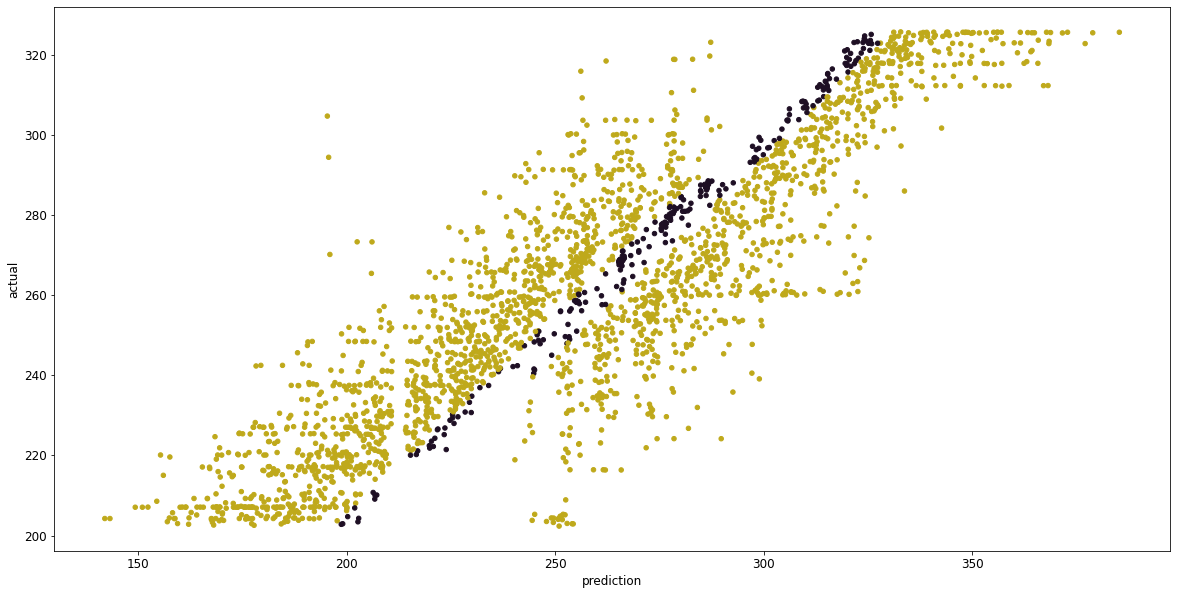

In [57]:
dfTrainsNextActual = dfTrainsLearn['nextValue']
showPredictions(dfTrainsNextBeop.tail(validationLength), dfTrainsNextActual.tail(validationLength))

In [58]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating a Decision Tree

In [59]:
to = fastai.load_pickle('/tmp/to.pkl')

In [60]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [61]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

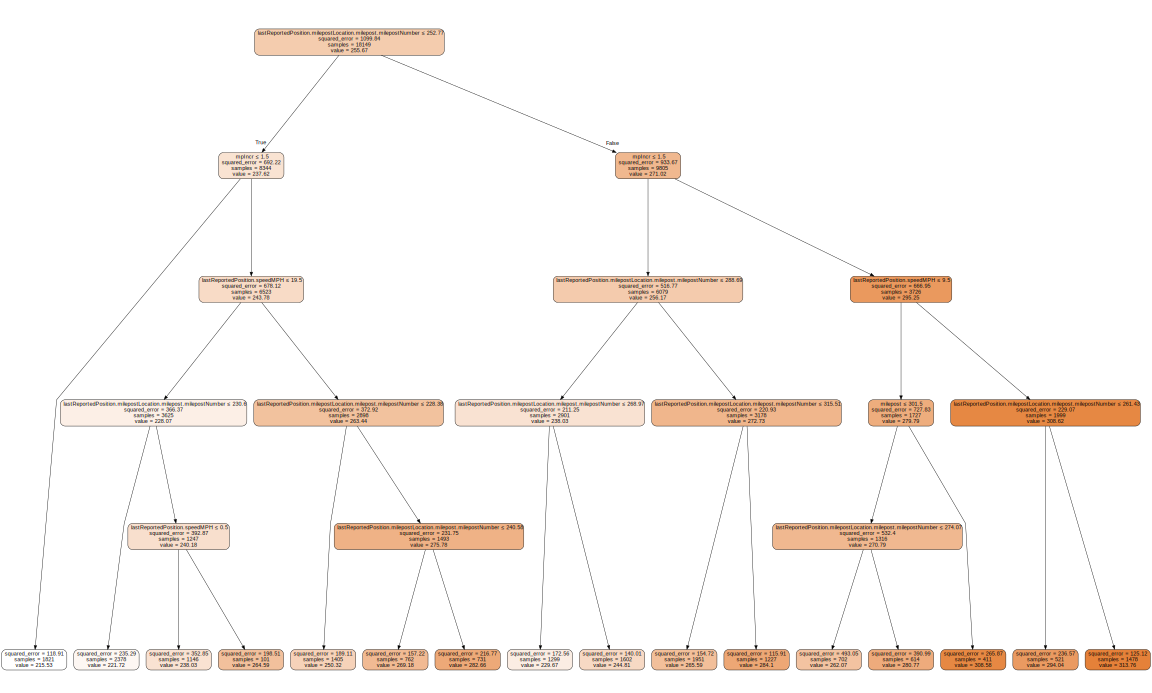

In [62]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [63]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

Root Mean Standard Error (RMSE)

How well we fit the training model:

In [64]:
trainingPreds = m.predict(xs)
r_mse(trainingPreds, y)

8.098305

How well we fit the Validation Model:

In [65]:
validationPreds = m.predict(valid_xs)
r_mse(validationPreds, valid_y)

13.549714

Simple Decision Tree Predictions:

      prediction      actual      delta
0     283.162222  291.374603   8.212381
1     272.500277  290.969177  18.468901
2     261.863200  282.523590  20.660390
3     257.050539  275.740753  18.690215
4     243.919424  245.180847   1.261423
...          ...         ...        ...
4356  243.335450  236.349045   6.986405
4357  225.554347  225.254959   0.299388
4358  214.193428  219.881546   5.688118
4359  218.302356  217.072906   1.229449
4360  213.186464  206.479767   6.706697

[4361 rows x 3 columns]
RMSE:  13.549714


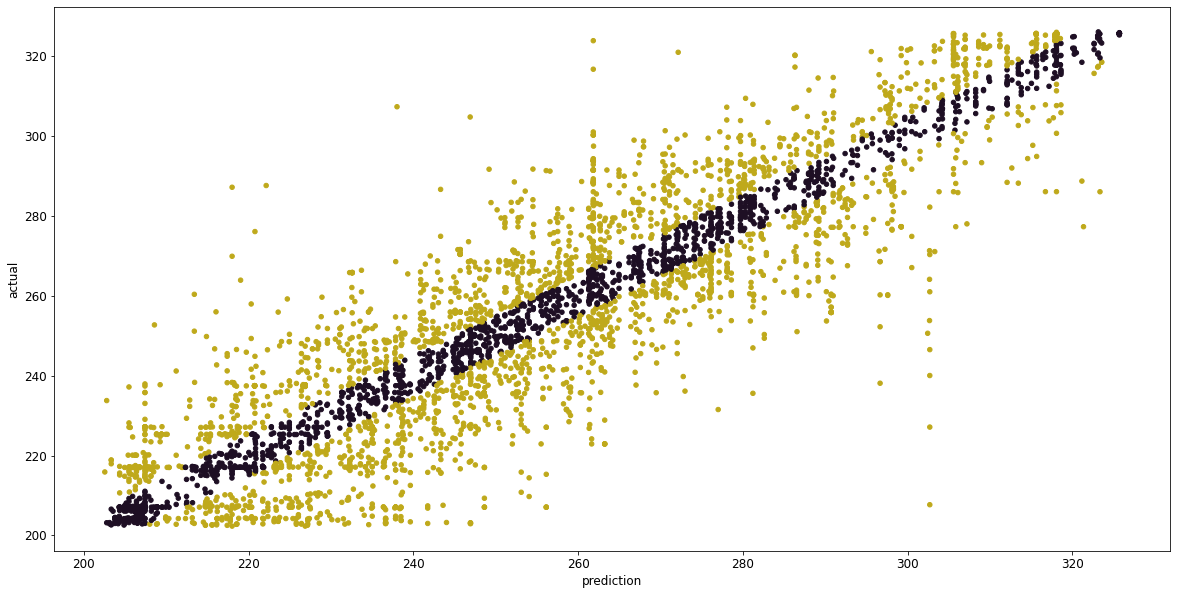

In [66]:
showPredictions(pd.DataFrame(validationPreds), valid_y)

In [67]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [68]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.485140
12,mpIncr,0.248480
22,lastReportedPosition.speedMPH,0.162622
38,milepost,0.025039
3,trainId.trainSymbol,0.016773
14,workLocations,0.009442
35,emptyCarCount,0.004471
24,aotuTrainData.totalCarWeight,0.003991
42,lastReportedPosition.positionTimeDay,0.003976
45,lastReportedPosition.positionTimeElapsed,0.003810


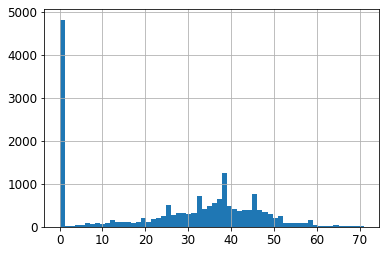

In [69]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


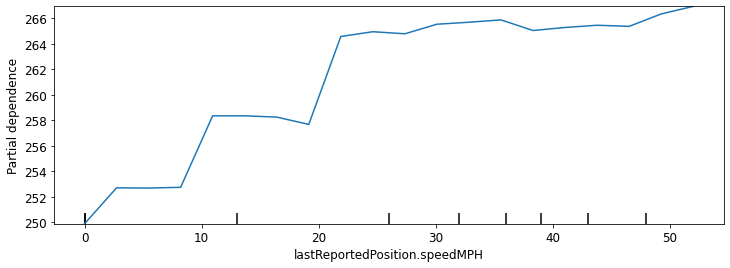

In [70]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

#Random Forest

In [71]:
def randomForest(xs, y, n_estimators=50, max_samples=10000,
       max_features=0.7, min_samples_leaf=7, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [72]:
m = randomForest(xs, y);

In [73]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(8.565274, 10.884364)

In [74]:
%%capture log
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Random Forest Predictions:

      prediction      actual      delta
0     286.289238  291.374603   5.085365
1     275.381775  290.969177  15.587402
2     273.085256  282.523590   9.438335
3     256.840155  275.740753  18.900598
4     241.305607  245.180847   3.875240
...          ...         ...        ...
4356  236.882713  236.349045   0.533668
4357  227.109055  225.254959   1.854096
4358  224.596887  219.881546   4.715341
4359  216.787998  217.072906   0.284908
4360  212.758832  206.479767   6.279066

[4361 rows x 3 columns]
RMSE:  10.884364


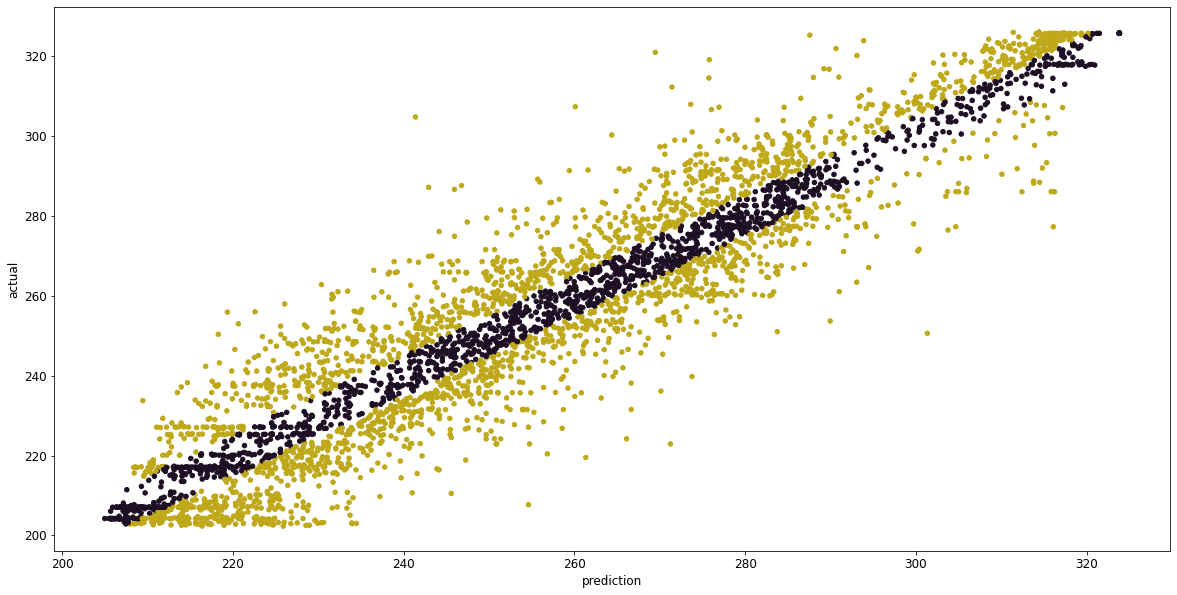

In [75]:
showPredictions(pd.DataFrame(preds.mean(0)), valid_y)


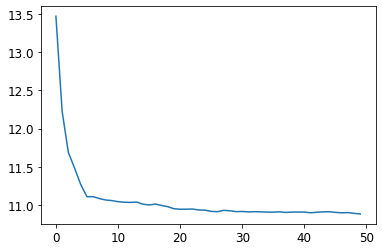

In [76]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

#Further Technical Inspections
Some checks for out-of-bag errors, etc.

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [77]:
r_mse(m.oob_prediction_, y)

10.413485

In [78]:
%%capture log
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [79]:
preds.shape

(50, 4361)

We can get the standard deviation of the predictions over all the trees, for each train:

In [80]:
preds_std = preds.std(0)

Standard Deviation for the predictions of the first 5 trains:


In [81]:
preds_std[:5]

array([6.32151517, 4.86514679, 8.69322047, 5.66580389, 7.35846494])

# FEATURE Importance

In [82]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.394014
12,mpIncr,0.256578
22,lastReportedPosition.speedMPH,0.141924
38,milepost,0.109783
3,trainId.trainSymbol,0.017221
14,workLocations,0.010086
34,loadedCarCount,0.005270
24,aotuTrainData.totalCarWeight,0.004806
6,lastReportedPosition.milepostLocation.trackName,0.004786
35,emptyCarCount,0.004780


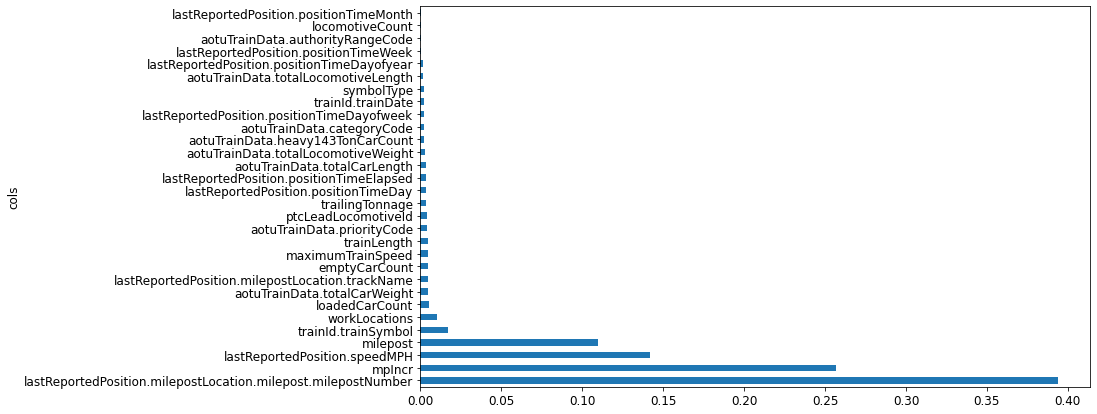

In [83]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [84]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

29

In [85]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [86]:
m = randomForest(xs_imp, y)

In [87]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(8.560576, 10.978666)

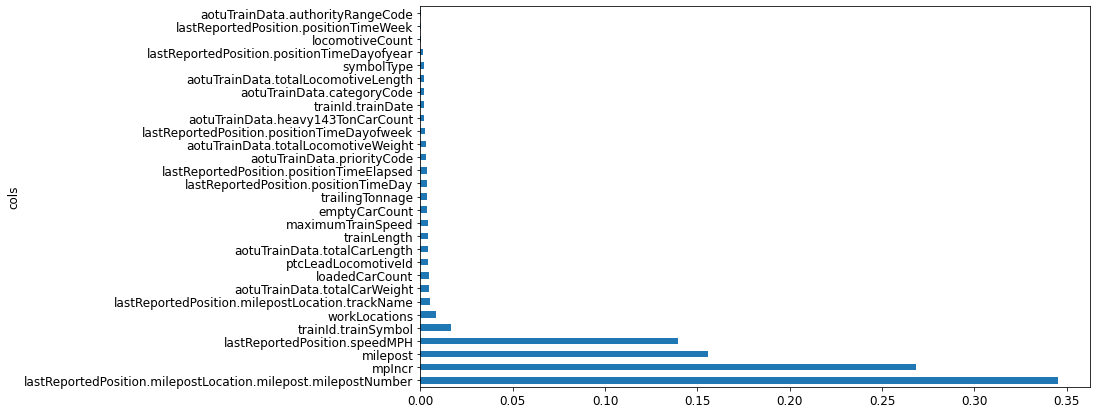

In [88]:
plot_fi(rf_feat_importance(m, xs_imp));

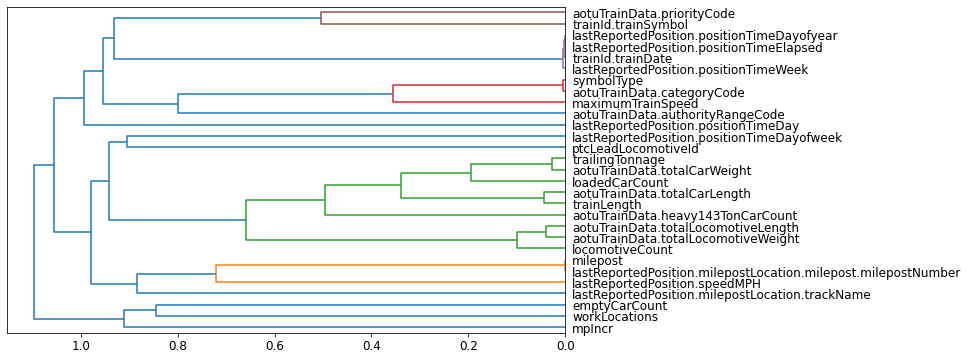

In [89]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [90]:
# showPredictions(dfTrainsNextBeop.tail(len(valid_y)), valid_y)

In [91]:
dfTrainsNextBeop

0        260.11060
1              NaN
2        269.01040
3        277.52255
4        291.03516
           ...    
29762    195.44986
29763    186.35670
29764    176.57133
29765          NaN
29766    174.76186
Name: beopValue, Length: 22510, dtype: float64

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [92]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.524125
45,lastReportedPosition.positionTimeElapsed,0.411666
41,lastReportedPosition.positionTimeWeek,0.032315
4,trainId.trainDate,0.031894
34,loadedCarCount,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000
27,aotuTrainData.totalLocomotiveLength,0.000000
28,aotuTrainData.actualTonsPerAxle,0.000000


Consider whether these values make sense

#Using a Neural Net

In [93]:
df_nn_final = dfTrainsLearn

In [94]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 29766
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            22510 non-null  object        
 1   trainId.trainSCAC                                              22510 non-null  category      
 2   trainId.trainSection                                           22510 non-null  category      
 3   trainId.trainSymbol                                            22510 non-null  object        
 4   trainId.trainDate                                              22510 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  22510 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            22510 non-null  int64         


In [95]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [96]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [97]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    1001
trainId.trainSCAC                                         2
trainId.trainSection                                      2
trainId.trainSymbol                                     311
trainId.trainDate                                       102
lastReportedPosition.speedMPH                            72
lastReportedPosition.milepostLocation.subdivisionId       1
lastReportedPosition.milepostLocation.trackName          11
aotuTrainData.priorityCode                                4
aotuTrainData.categoryCode                               11
aotuTrainData.authorityRangeCode                          3
aotuTrainData.ownershipCode                               3
aotuTrainData.eventCode                                   1
milepost                                                123
mpIncr                                                    2
symbolType                                               12
workLocations                           

In [98]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [99]:
dls = to_nn.dataloaders(1024)

In [100]:
y = to_nn.train.y
y.min(),y.max()

(202.23622, 326.0935)

In [101]:
linearLayers=500
activations=250
learn = tabular_learner(dls, y_range=(202,327), layers=[linearLayers,activations],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0005754399462603033)

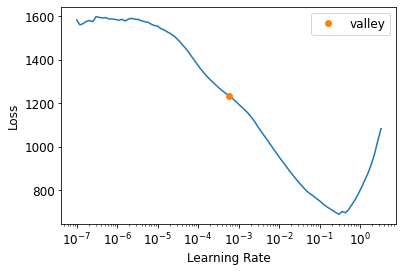

In [102]:
learn.lr_find()

In [103]:
# Default NN 
# learn.fit_one_cycle(50, 1e-4)

In [104]:
#"Ranger" Optimizer Uses Pytorch’s CosineAnnealing
learn.fit_flat_cos(20, 1e-4)

epoch,train_loss,valid_loss,time
0,887.909851,1121.656738,00:01
1,739.006958,1009.620178,00:01
2,633.591553,754.783936,00:01
3,529.498352,514.782898,00:01
4,437.850342,380.259552,00:01
5,357.605286,336.037781,00:01
6,296.815430,305.518280,00:01
7,248.764221,290.872284,00:01
8,214.551239,279.021393,00:01
9,185.953079,275.887512,00:01


In [105]:
# Stochastic Gradient Descent
# Too Much Ram -  cannot run here 
# learn.fit_sgdr(31, 10)

NN Predictions:

      prediction      actual      delta
0     282.352051  291.374603   9.022552
1     271.937378  290.969177  19.031799
2     261.226105  282.523590  21.297485
3     250.949783  275.740753  24.790970
4     224.147507  245.180847  21.033340
...          ...         ...        ...
4356  244.014984  236.349045   7.665939
4357  234.802292  225.254959   9.547333
4358  228.098679  219.881546   8.217133
4359  225.487122  217.072906   8.414215
4360  220.807922  206.479767  14.328156

[4361 rows x 3 columns]
RMSE:  15.871988


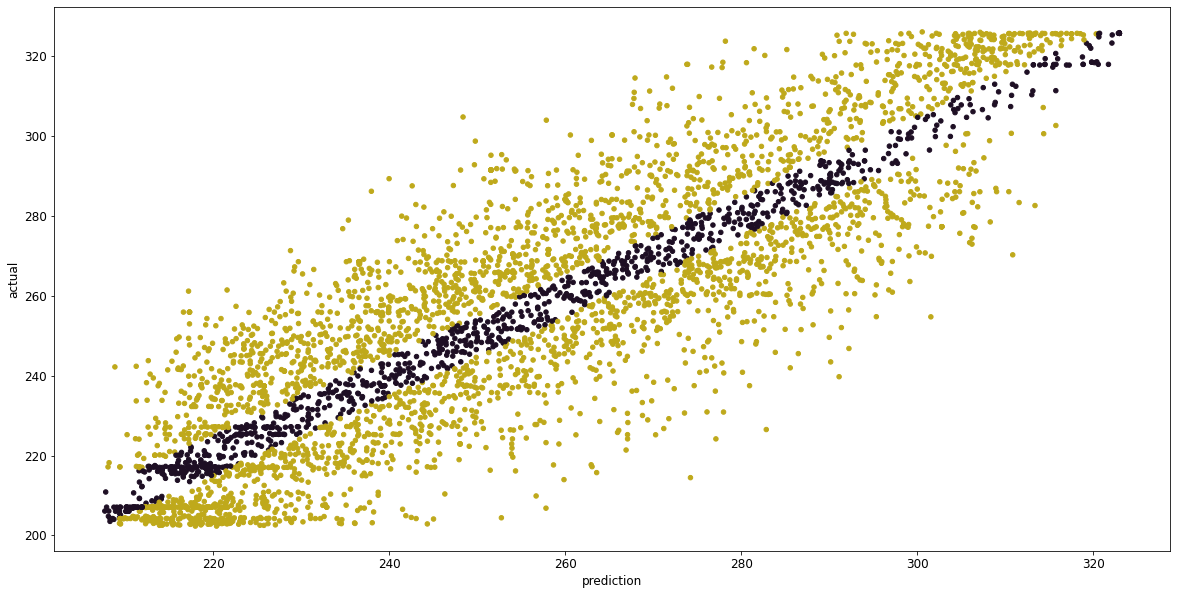

In [106]:
preds,targs = learn.get_preds()
showPredictions(pd.DataFrame(preds.numpy(), columns=['prediction']), 
                pd.DataFrame(targs.numpy(), columns=['actual']))